## CommonLit Readability Challenge

### Imports

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Loading the training dataset

In [12]:
read_df = pd.read_csv("train.csv")

### Attributes

In [13]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2834 entries, 0 to 2833
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2834 non-null   object 
 1   url_legal       830 non-null    object 
 2   license         830 non-null    object 
 3   excerpt         2834 non-null   object 
 4   target          2834 non-null   float64
 5   standard_error  2834 non-null   float64
dtypes: float64(2), object(4)
memory usage: 133.0+ KB


In [14]:
read_df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [15]:
read_df['target'].describe()

count    2834.000000
mean       -0.959319
std         1.033579
min        -3.676268
25%        -1.690320
50%        -0.912190
75%        -0.202540
max         1.711390
Name: target, dtype: float64

## Correlation between target column and standard error

In [16]:
read_df[['target','standard_error']].corr()

,target,standard_error
target,1.000000,-0.085981
standard_error,-0.085981,1.000000


<AxesSubplot:>

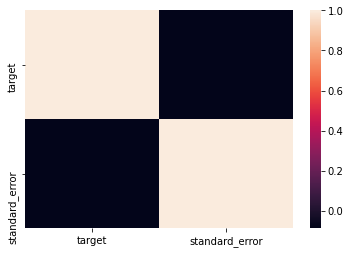

In [17]:
sns.heatmap(read_df[['target','standard_error']].corr())

### Preprocessing the excerpt column to remove common words, using a stemmer

In [18]:
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [19]:
import re
def remove_links(text):
    wnl=WordNetLemmatizer()
    text = re.sub(r'\d+', "", text)
    text = re.sub('http://\S+|https://\S+', '', text)
    emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  
                        u"\U0001F680-\U0001F6FF"  
                        u"\U0001F1E0-\U0001F1FF"  
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r'@\w+',  '', text).strip()
    text = re.sub("[^a-zA-Z0-9 ']", "", text)
    text=' '.join([wnl.lemmatize(i) for i in text.lower().split()])
    
    return text

In [20]:
import string
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [54]:
read_df['excerpt'] = read_df['excerpt'].apply(remove_links)

In [21]:
read_df['excerpt']

0       When the young people returned to the ballroom...
1       All through dinner time, Mrs. Fayre was somewh...
2       As Roger had predicted, the snow departed as q...
3       And outside before the palace a great garden w...
4       Once upon a time there were Three Bears who li...
                              ...                        
2829    When you think of dinosaurs and where they liv...
2830    So what is a solid? Solids are usually hard be...
2831    The second state of matter we will discuss is ...
2832    Solids are shapes that you can actually touch....
2833    Animals are made of many cells. They eat thing...
Name: excerpt, Length: 2834, dtype: object

### Exploratory Data Analysis

In [22]:
read_df_above_50 = read_df[read_df['target']>0.912190].copy()

In [23]:
read_df_below_50 = read_df[read_df['target']<=0.912190].copy()

In [24]:
read_df_above_50['text_length'] = read_df_above_50['excerpt'].apply(len)

In [25]:
read_df_below_50['text_length'] = read_df_below_50['excerpt'].apply(len)

In [26]:
read_df_above_50['text_length'].value_counts()

1009    3
805     3
837     2
961     2
1074    2
       ..
844     1
1097    1
968     1
1095    1
896     1
Name: text_length, Length: 65, dtype: int64

<AxesSubplot:xlabel='text_length'>

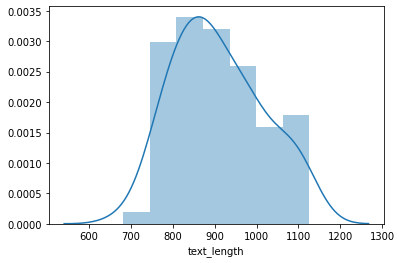

In [27]:
sns.distplot(read_df_above_50['text_length'])

<AxesSubplot:xlabel='text_length'>

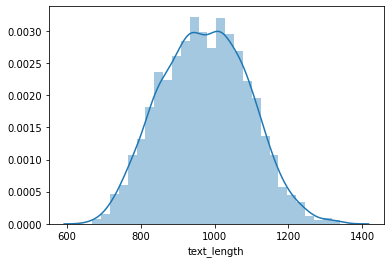

In [28]:
sns.distplot(read_df_below_50['text_length'])

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
corpus_above_50 = list(read_df_above_50['excerpt'])

In [31]:
corpus_below_50 = list(read_df_below_50['excerpt'])

In [32]:
vectorizer = TfidfVectorizer()
X_above50 = vectorizer.fit_transform(corpus_above_50)
vectorizer1 = TfidfVectorizer()
X_below50 = vectorizer1.fit_transform(corpus_below_50)

In [33]:
def getTopKeywords(vectorizer,n_value):
    feature_array = np.array(vectorizer.get_feature_names())
    tfidf_sorting = np.argsort(X_above50.toarray()).flatten()[::-1]
    top_n = feature_array[tfidf_sorting][:n_value]
    return top_n

In [34]:
top_keywords_above_50 = getTopKeywords(vectorizer,20)
top_keywords_below_50 = getTopKeywords(vectorizer1,50)

In [38]:
def returnKeywordsCount(top_keywords,corpus):
    keywords = dict()
    for words in corpus:
        for i in top_keywords:
            if i in words:
                if i not in keywords:
                    keywords[i]=1
                else:
                    keywords[i]+=1

    return keywords
            

In [36]:
def returnPunctuationCount(corpus):
    dic = dict()
    for words in corpus:
        for i in words:
            if i in string.punctuation:
                if i not in dic:
                    dic[i] = 1
                else:
                    dic[i]+=1
    return dic



In [39]:
keywords_count_above_50 = returnKeywordsCount(top_keywords_above_50,corpus_above_50)
keywords_count_below_50 = returnKeywordsCount(top_keywords_below_50,corpus_below_50)

In [40]:
punc_count1 = returnPunctuationCount(corpus_above_50)
punc_count2 = returnPunctuationCount(corpus_below_50)

In [41]:
punc_above_50 = []
punc_above_50.append(list(punc_count1.keys()))
punc_above_50.append(list(punc_count1.values()))
punc_below_50 = []
punc_below_50.append(list(punc_count2.keys()))
punc_below_50.append(list(punc_count2.values()))

In [42]:
key_count1 = []
key_count2 = []
key_count1.append(list(keywords_count_above_50.keys()))
key_count1.append(list(keywords_count_above_50.values()))
key_count2.append(list(keywords_count_below_50.keys()))
key_count2.append(list(keywords_count_below_50.values()))

In [43]:
%matplotlib inline

In [44]:
plt.style.use('seaborn-bright')

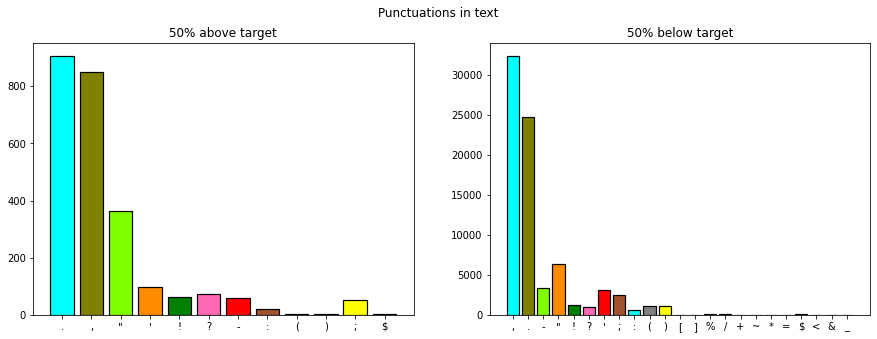

In [47]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.bar(punc_above_50[0],punc_above_50[1],color=colors,edgecolor='black', linewidth=1.2)
ax1.set_title("50% above target")
ax2.bar(punc_below_50[0],punc_below_50[1],color=colors,edgecolor='black', linewidth=1.2)
ax2.set_title("50% below target")
plt.suptitle("Punctuations in text")
plt.show()

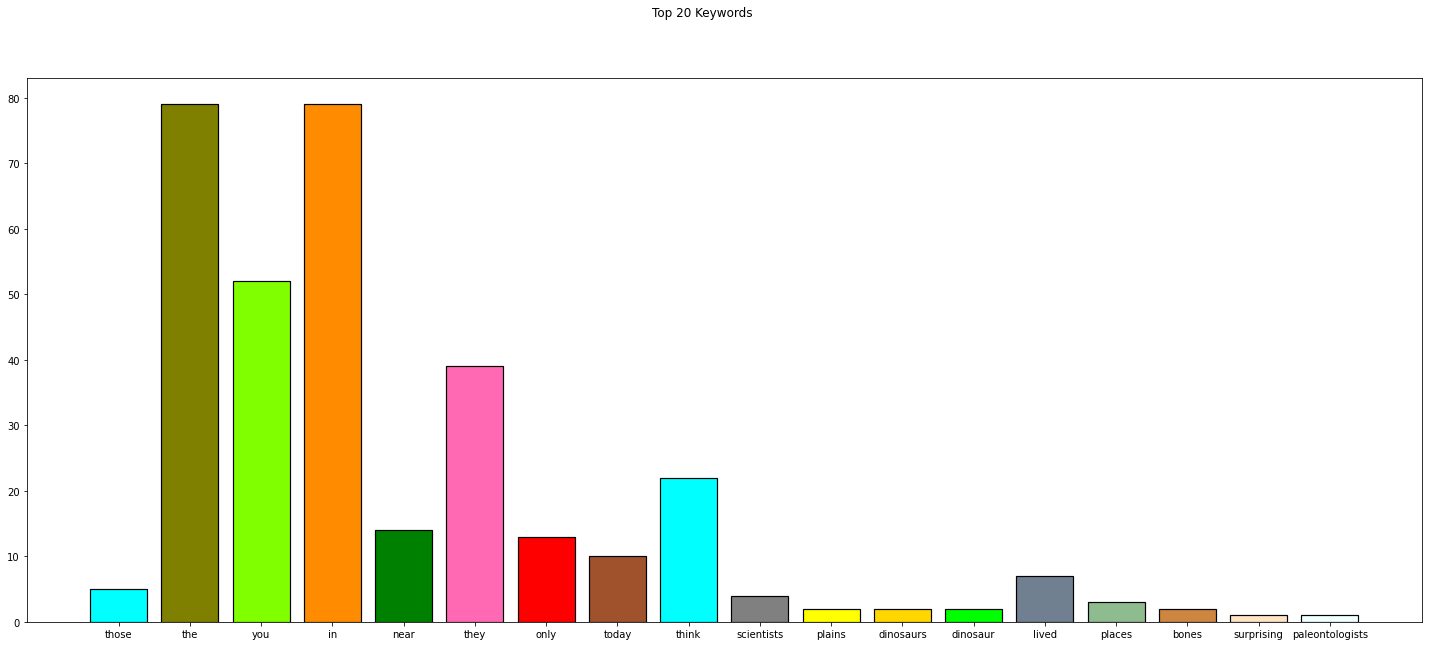

In [46]:
colors = ['aqua','olive','chartreuse','darkorange','green','hotpink','red','sienna','cyan','grey','yellow','gold','lime','slategray','darkseagreen','peru','bisque','azure','steelblue','violet']
fig1,ax1 = plt.subplots(1,1,figsize=(25,10))
ax1.bar(key_count1[0],key_count1[1],color=colors,edgecolor='black', linewidth=1.2)
plt.suptitle("Top 20 Keywords")
plt.show()

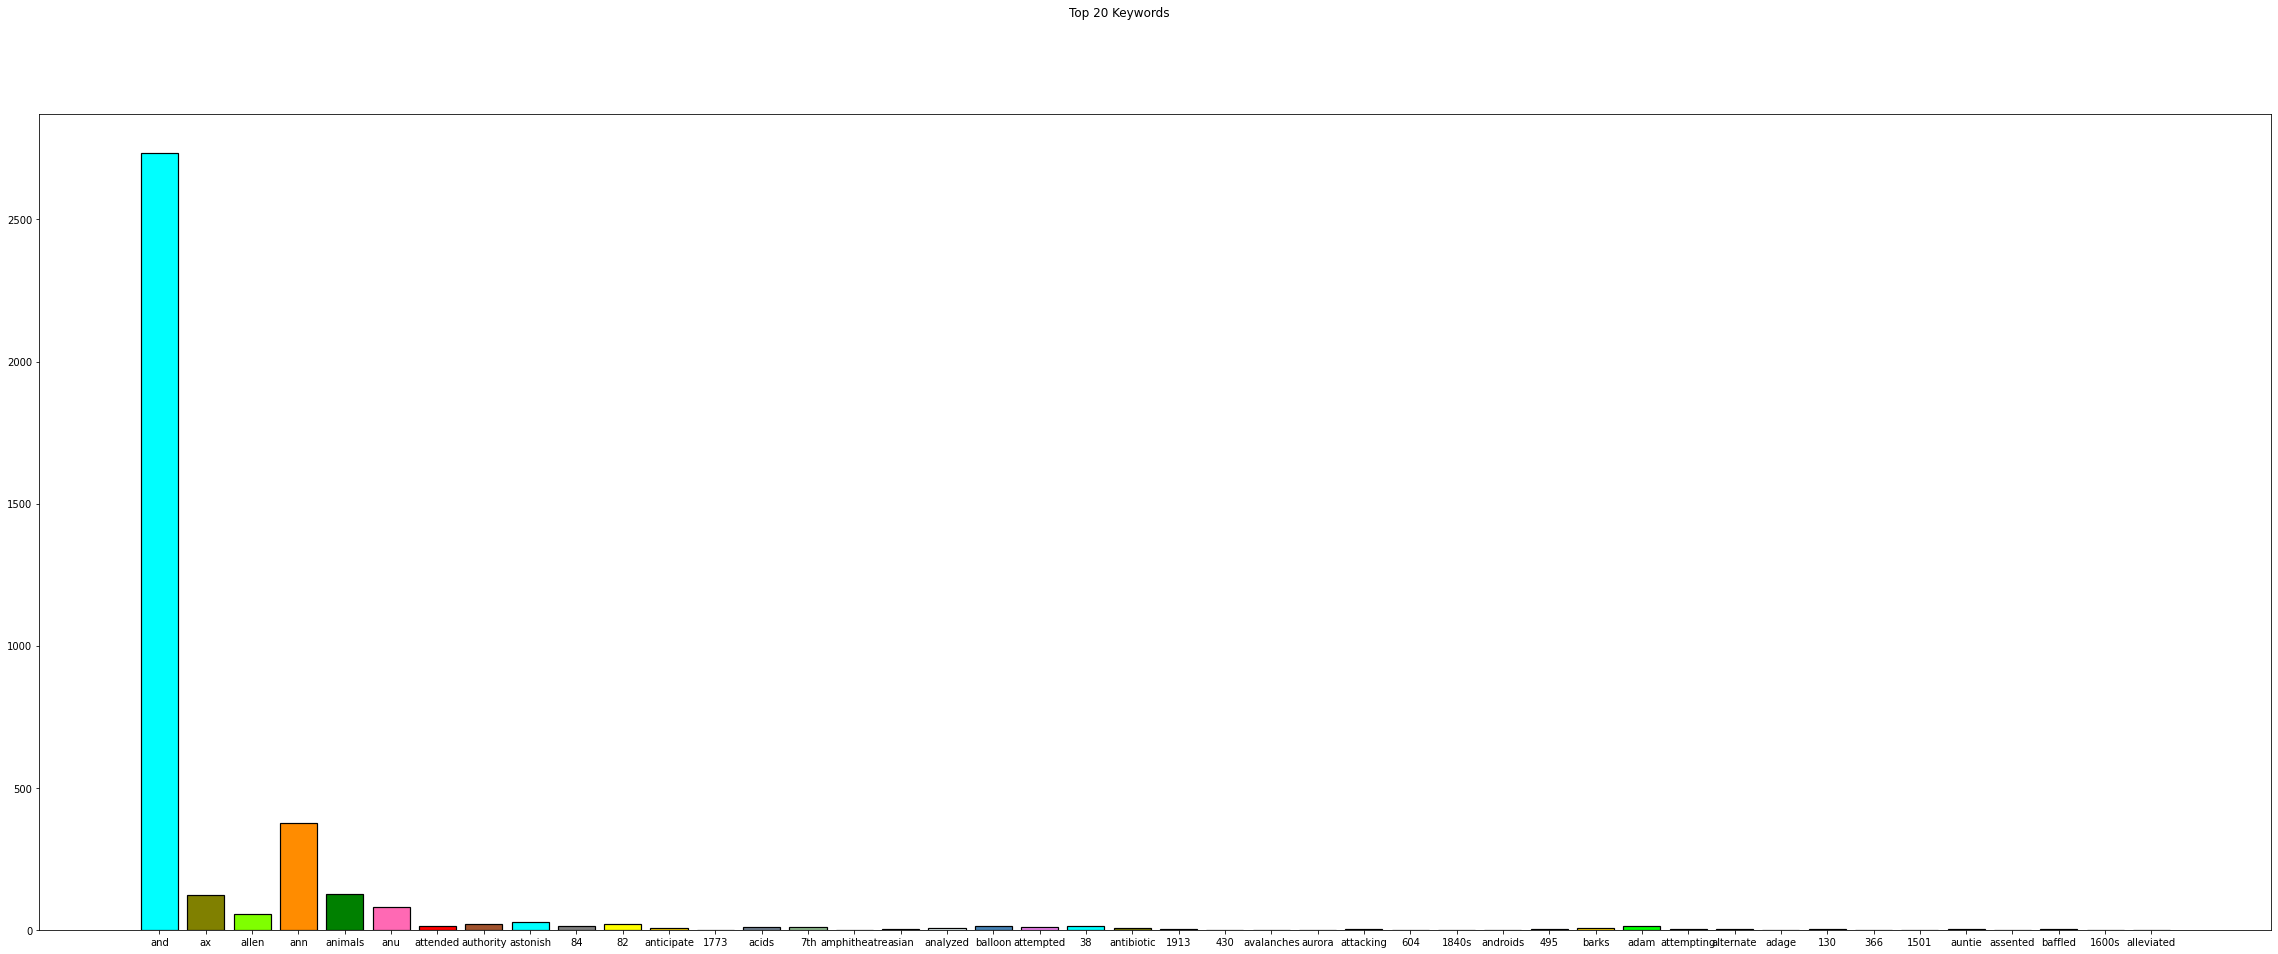

In [52]:
colors = ['aqua','olive','chartreuse','darkorange','green','hotpink','red','sienna','cyan','grey','yellow','gold','lime','slategray','darkseagreen','peru','bisque','azure','steelblue','violet']
fig2,ax2 = plt.subplots(1,1,figsize=(40,15))
ax2.bar(key_count2[0],key_count2[1],color=colors,edgecolor='black', linewidth=1.2)
plt.suptitle("Top 20 Keywords")
plt.show()

In [56]:
from sklearn.model_selection import train_test_split

In [57]:
X_train,X_test,y_train,y_test = train_test_split(read_df['excerpt'],read_df['target'],random_state=42)

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [ ]:
lr = LinearRegression()

In [58]:
from sklearn.pipeline import Pipeline

In [59]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


In [85]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),# strings to token integer counts  # integer counts to weighted TF-IDF scores
    ('regressor', Ridge(alpha=10.0)),
])

In [86]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7fb4c43ca1f0>)),
                ('tfidf', TfidfTransformer()),
                ('regressor', Ridge(alpha=10.0))])

In [84]:
from sklearn.linear_model import RidgeCV

In [ ]:
regr_cv = RidgeCV(alphas=[0.1, 1.0, 10.0])

In [ ]:
regr_cv

In [ ]:
X_train

In [82]:
pred = pipeline.predict(X_test)

In [83]:
from sklearn.metrics import mean_squared_error
mean_squared_error(pred,y_test)

0.5682046657042158

In [ ]:
test_df = pd.read_csv('test.csv')

In [ ]:
test_df['excerpt'] = test_df['excerpt'].apply(remove_links)

In [ ]:
test_preds = pipeline.predict(test_df['excerpt'])

In [ ]:
submission = pd.DataFrame({'id':test_df['id'],'target':test_preds})

In [ ]:
submission.to_csv("submissions.csv",index=False)

In [71]:
from sklearn.linear_model import Ridge

In [ ]:
clf = Ridge(alpha=1.0)
clf.fit(X)